In [1]:
# compare result from TOMOATT and fortran code

fpath_kernel_fort = './fortran_code/ega5/output/tele_event_kernel_ev1'
#fpath_synth_fort = './fortran_code/ega5/output/syn_step1_event1' # Table
#fpath_adj_fort = './fortran_code/ega5/output/adj_step1_event1' # TableADJ

# HDF5 output
fpath_out_tomoatt = './OUTPUT_FILES/out_data_sim_0.h5'
fpath_grid_tomoatt = './OUTPUT_FILES/out_data_grid.h5'
# ASCII output
fpath_out_tomoatt_ascii_Ks = './OUTPUT_FILES/Ks_inv_0000.dat'
fpath_out_tomoatt_ascii_Keta = './OUTPUT_FILES/Keta_inv_0000.dat'
fpath_out_tomoatt_ascii_Kxi = './OUTPUT_FILES/Kxi_inv_0000.dat'
fpath_out_tomoatt_ascii_T  = './OUTPUT_FILES/T_res_inv_0000_src_0000.dat'
fpath_out_tomoatt_ascii_adj = './OUTPUT_FILES/adjoint_field_inv_0000_src_0000.dat'

# grid information in fortran code
nr = 55
nt = 55
np = 55
npoints = nr*nt*np

# division
ndiv_r = 1 
ndiv_t = 2 
ndiv_p = 2  

In [2]:
import h5py
import numpy


# read fortran test file and convert to numpy array
def read_fortran_result_file(fpath):
    with open(fpath, 'r') as f:
        lines = f.readlines()
        lines = [line.strip() for line in lines]
        lines = [line for line in lines if line]
        lines = [line.split() for line in lines]
        lines = numpy.array(lines, dtype=numpy.float64)
        return lines

fortran_data = read_fortran_result_file(fpath_kernel_fort)
## change dimension of fortran data
Ks_fort = fortran_data[:,3].reshape(nr, nt, np)
Kxi_fort = fortran_data[:,4].reshape(nr, nt, np)
Keta_fort = fortran_data[:,5].reshape(nr, nt, np)
Syn_fort = fortran_data[:,6].reshape(nr, nt, np)
Adj_fort = fortran_data[:,7].reshape(nr, nt, np)

#fortran_synth_data = read_fortran_result_file(fpath_synth_fort).reshape(nr, nt, np)
#fortran_adj_data = read_fortran_result_file(fpath_adj_fort).reshape(nr, nt, np)

In [3]:
# read h5 data
import sys
sys.path.append("../../utils/")

from tomoatt_data_retrieval import get_data_from_h5
from tomoatt_data_retrieval import get_data_from_ascii


## from h5
i_inv=0
# fill 0 at flont of i_inv
str_i_inv = str(i_inv).zfill(4)
Ks_tomoatt   ,_,_,_= get_data_from_h5(fpath_out_tomoatt,  fpath_grid_tomoatt, "Data/Ks_inv_{}".format(str_i_inv), nr, nt, np, ndiv_r, ndiv_t, ndiv_p, verbose=True)
Kxi_tomoatt  ,_,_,_= get_data_from_h5(fpath_out_tomoatt, fpath_grid_tomoatt, "Data/Kxi_inv_{}".format(str_i_inv), nr, nt, np, ndiv_r, ndiv_t, ndiv_p)
Keta_tomoatt ,_,_,_= get_data_from_h5(fpath_out_tomoatt,fpath_grid_tomoatt, "Data/Keta_inv_{}".format(str_i_inv), nr, nt, np, ndiv_r, ndiv_t, ndiv_p)
Syn_tomoatt  ,_,_,_= get_data_from_h5(fpath_out_tomoatt, fpath_grid_tomoatt, "Data/T_res_src_0_inv_{}".format(str_i_inv), nr, nt, np, ndiv_r, ndiv_t, ndiv_p)
Adj_tomoatt  ,_,_,_= get_data_from_h5(fpath_out_tomoatt, fpath_grid_tomoatt, "Data/adjoint_field_src_0_inv_{}".format(str_i_inv), nr, nt, np, ndiv_r, ndiv_t, ndiv_p)

## from ascii
#Ks_tomoatt = get_data_from_ascii(fpath_out_tomoatt_ascii_Ks, nr, nt, np, ndiv_r, ndiv_t, ndiv_p)
#Kxi_tomoatt = get_data_from_ascii(fpath_out_tomoatt_ascii_Kxi, nr, nt, np, ndiv_r, ndiv_t, ndiv_p)
#Keta_tomoatt = get_data_from_ascii(fpath_out_tomoatt_ascii_Keta, nr, nt, np, ndiv_r, ndiv_t, ndiv_p)
#Syn_tomoatt = get_data_from_ascii(fpath_out_tomoatt_ascii_T, nr, nt, np, ndiv_r, ndiv_t, ndiv_p)
#Adj_tomoatt = get_data_from_ascii(fpath_out_tomoatt_ascii_adj, nr, nt, np, ndiv_r, ndiv_t, ndiv_p)

In [4]:
# normalize Ks_tomoatt and Kxi_tomoatt and Keta_tomoatt
Ks_tomoatt /= numpy.max(Ks_tomoatt)
Kxi_tomoatt /= numpy.max(Kxi_tomoatt)
Keta_tomoatt /= numpy.max(Keta_tomoatt)

In [5]:
# plot slice of Ks_inv
import matplotlib.pyplot as plt

def plot_slice(data_es, data_fort, slice_ax, id_slice, contour=False):

    if (slice_ax == 'r'):
        data_es_v   = data_es[  id_slice, :, :]
        data_fort_v = data_fort[id_slice, :, :]
    elif (slice_ax == 't'):
        data_es_v   = data_es[  :, id_slice, :]
        data_fort_v = data_fort[:, id_slice, :]
    elif (slice_ax == 'p'):
        data_es_v   = data_es[  :, :, id_slice]
        data_fort_v = data_fort[:, :, id_slice]
    else:
        print("Error: slice_ax should be 'r', 't' or 'p'")
        return

    # use the same color range for both tomoatt and fortran   
    combined_data = numpy.array([data_es_v.flatten(),data_fort_v.flatten()])
    #Get the min and max of all your data
    _min, _max = numpy.amin(combined_data), numpy.amax(combined_data)

    # make the color range symmetric
    diff_data = data_es_v-data_fort_v
    _min_diff, _max_diff = numpy.amin(diff_data), numpy.amax(diff_data)
    if (abs(_min_diff) > abs(_max_diff)):
        if (_min_diff < 0):
            _max_diff = -_min_diff
    else:
        _min_diff = -_max_diff

    cmap1="viridis"
    cmap2="seismic"

    plt.figure(figsize=(20,10))

    plt.subplot(1,3,1)
    plt.imshow(data_es_v, cmap=cmap1, vmin=_min, vmax=_max)
    plt.colorbar()
    if(contour):
        plt.contour(data_es_v, colors='k', linewidths=0.5)
    plt.title('result_tomoatt')

    plt.subplot(1,3,2)
    plt.imshow(data_fort_v, cmap=cmap1, vmin=_min, vmax=_max)
    plt.colorbar()
    if(contour): 
        plt.contour(data_fort_v, colors='k', linewidths=0.5)
    plt.title('result_fort')
    
    plt.subplot(1,3,3)
    plt.imshow(diff_data, cmap=cmap2, vmin=_min_diff, vmax=_max_diff)
    plt.colorbar()
    if(contour):
        plt.contour(diff_data, colors='k', linewidths=0.5) 
    plt.title('tomoatt-fort')
    plt.show()


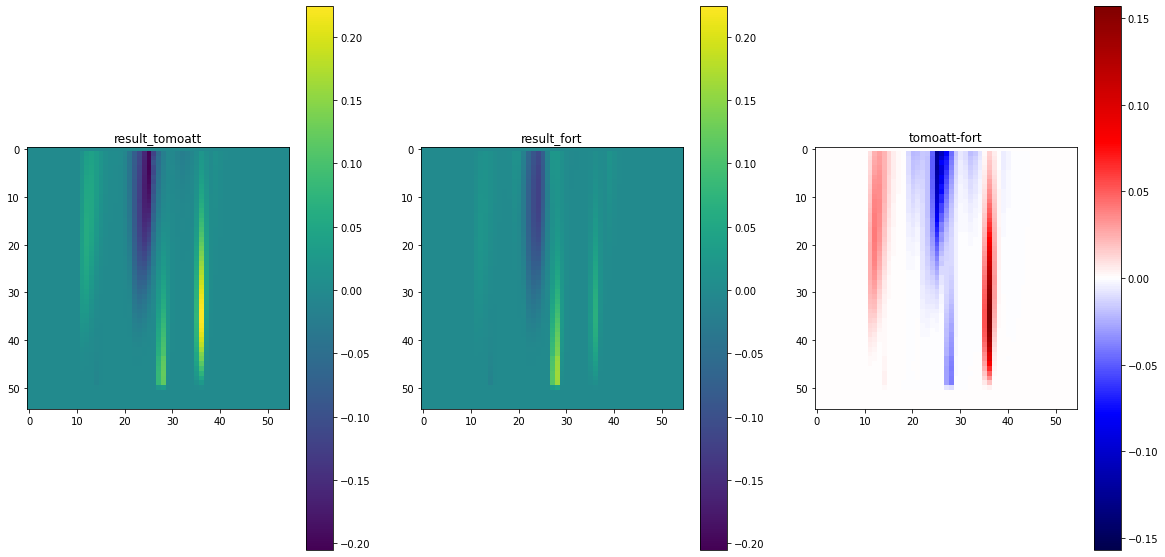

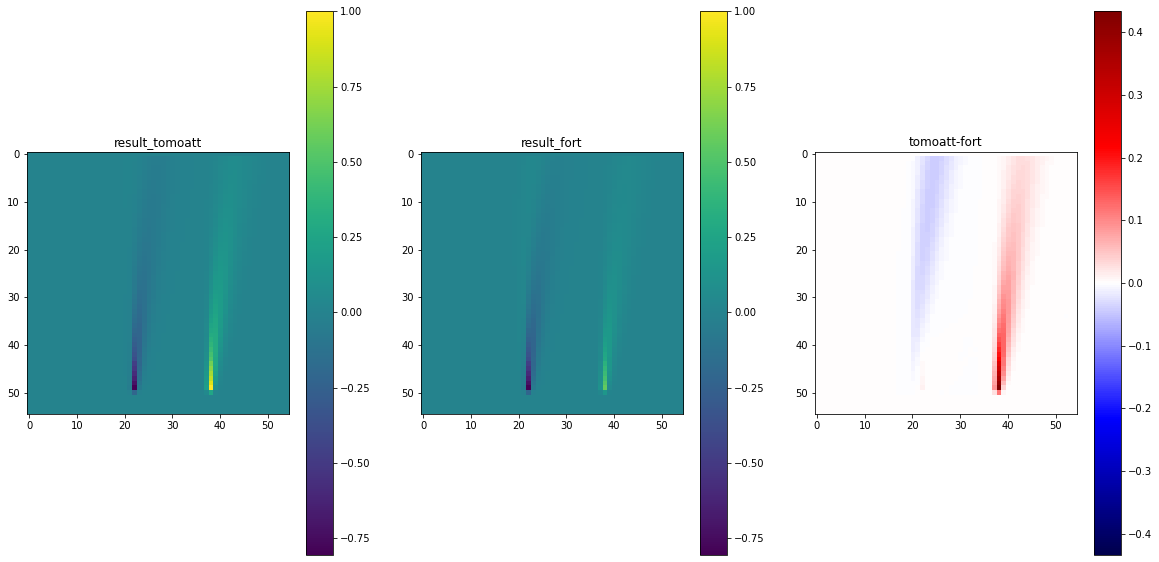

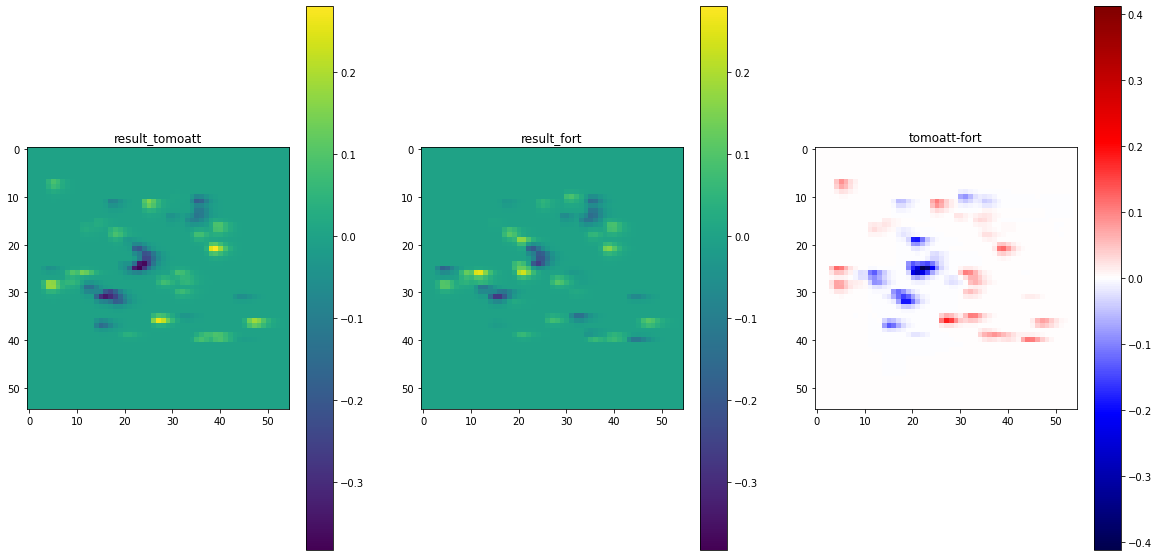

In [6]:
plot_slice(Ks_tomoatt, Ks_fort, 'p', 28)
plot_slice(Ks_tomoatt, Ks_fort, 't', 21)
plot_slice(Ks_tomoatt, Ks_fort, 'r', 36)

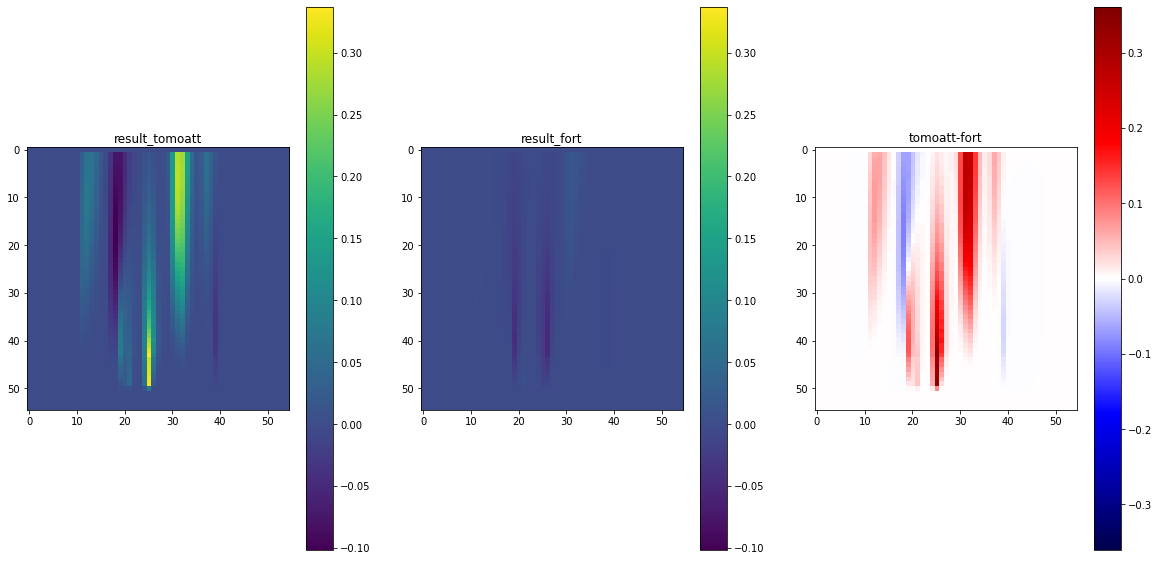

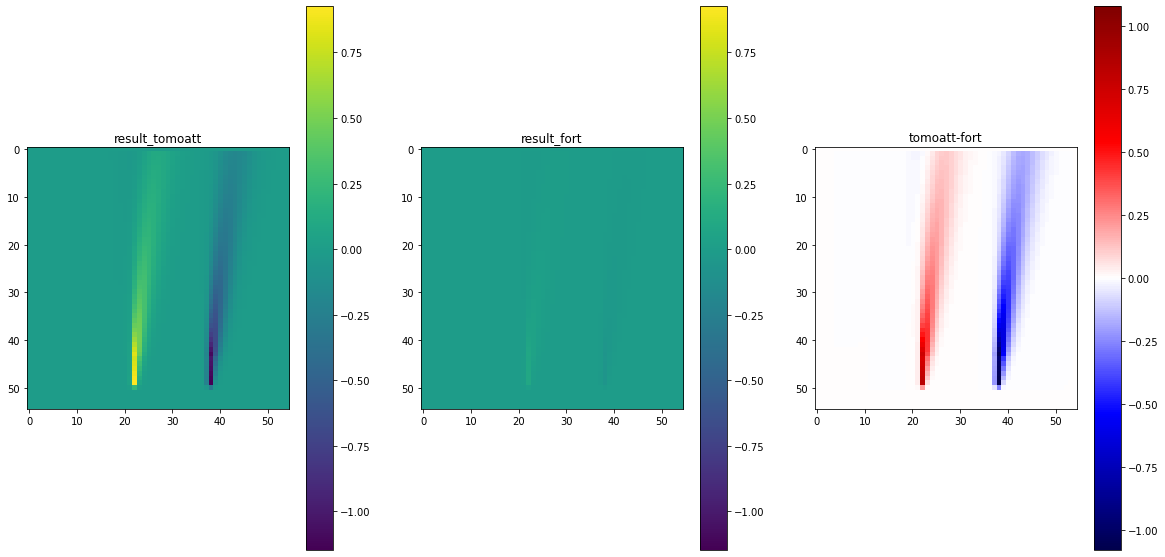

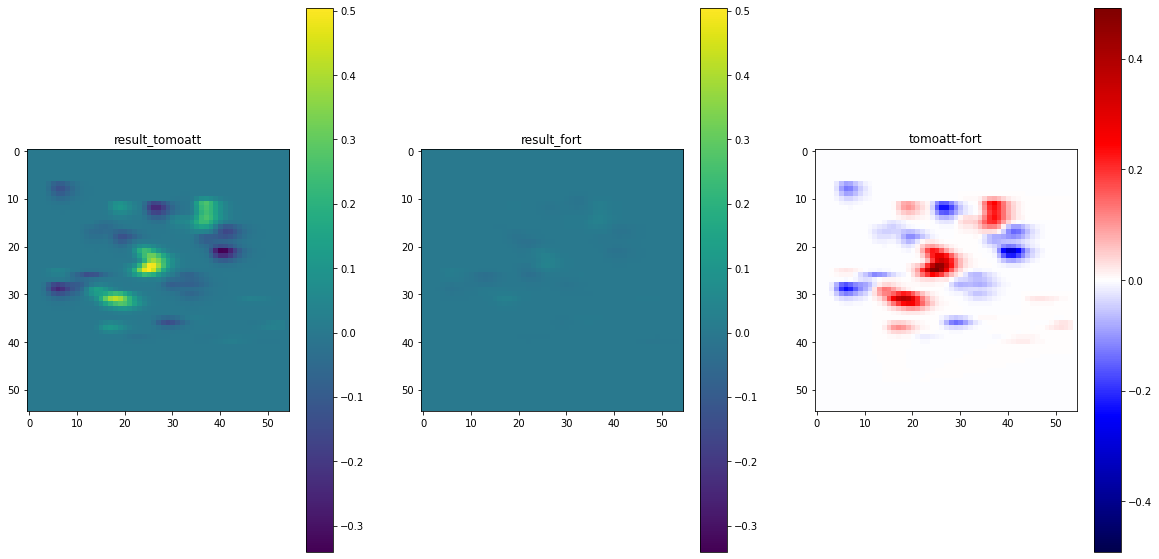

In [7]:
plot_slice(Keta_tomoatt, Keta_fort, 'p', 21, contour=False)
plot_slice(Keta_tomoatt, Keta_fort, 't', 21, contour=False)
plot_slice(Keta_tomoatt, Keta_fort, 'r', 21, contour=False)


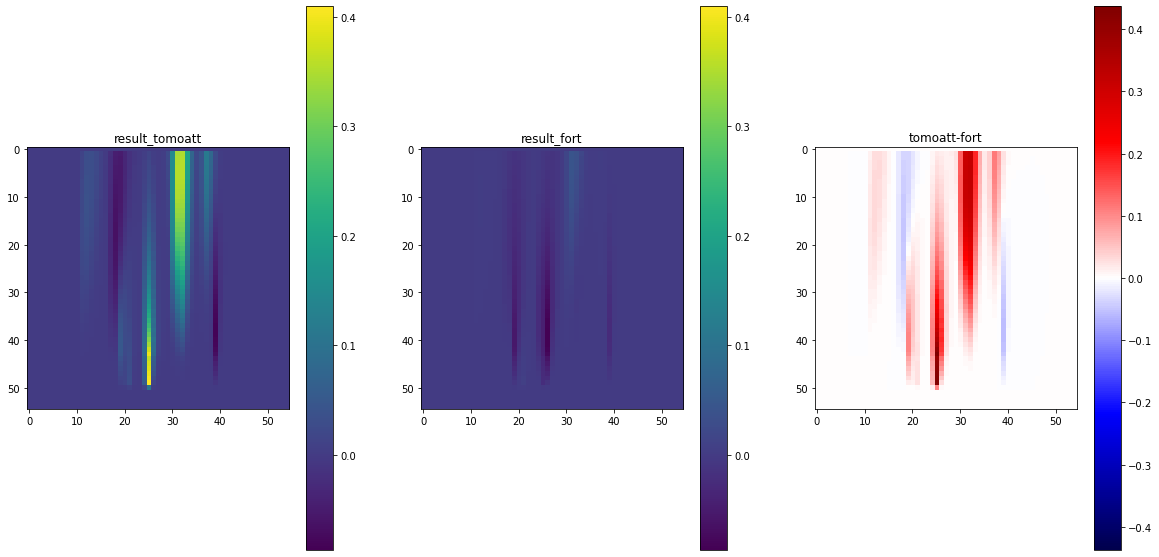

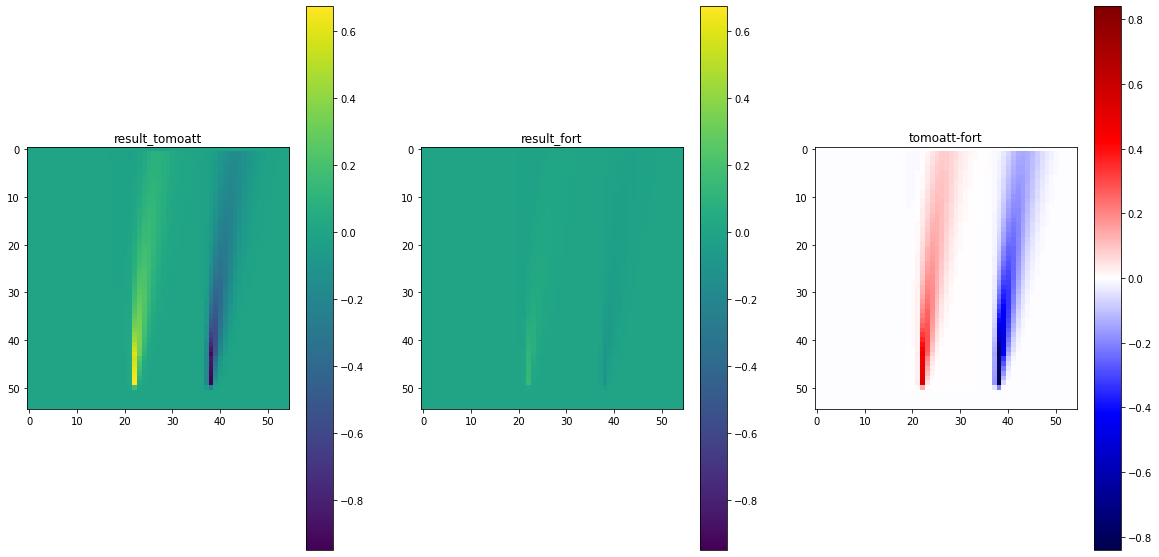

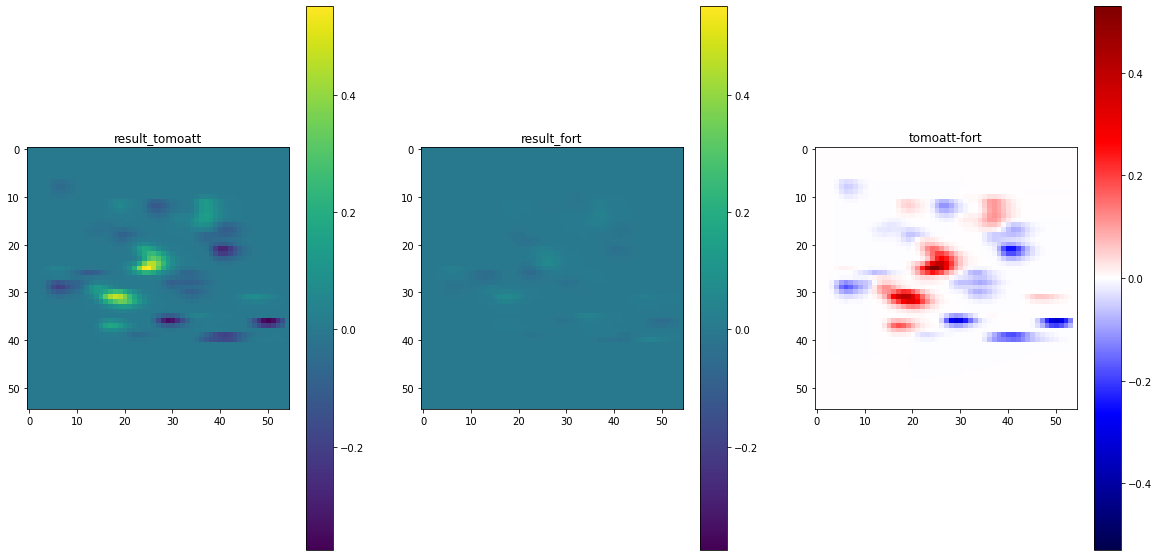

In [8]:
plot_slice(Kxi_tomoatt, Kxi_fort, 'p', 21, contour=False)
plot_slice(Kxi_tomoatt, Kxi_fort, 't', 21, contour=False)
plot_slice(Kxi_tomoatt, Kxi_fort, 'r', 21, contour=False)


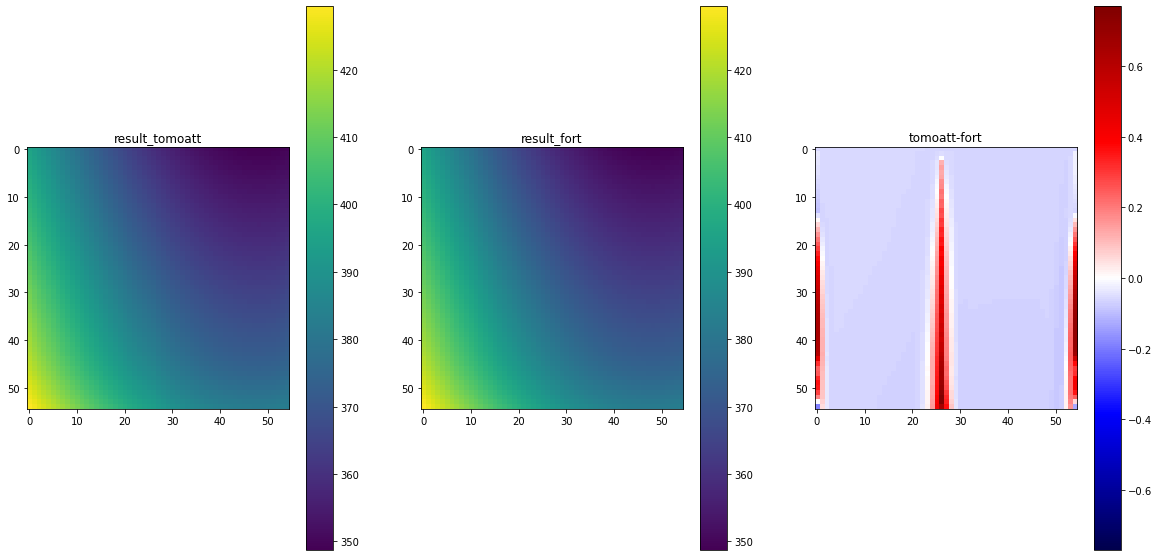

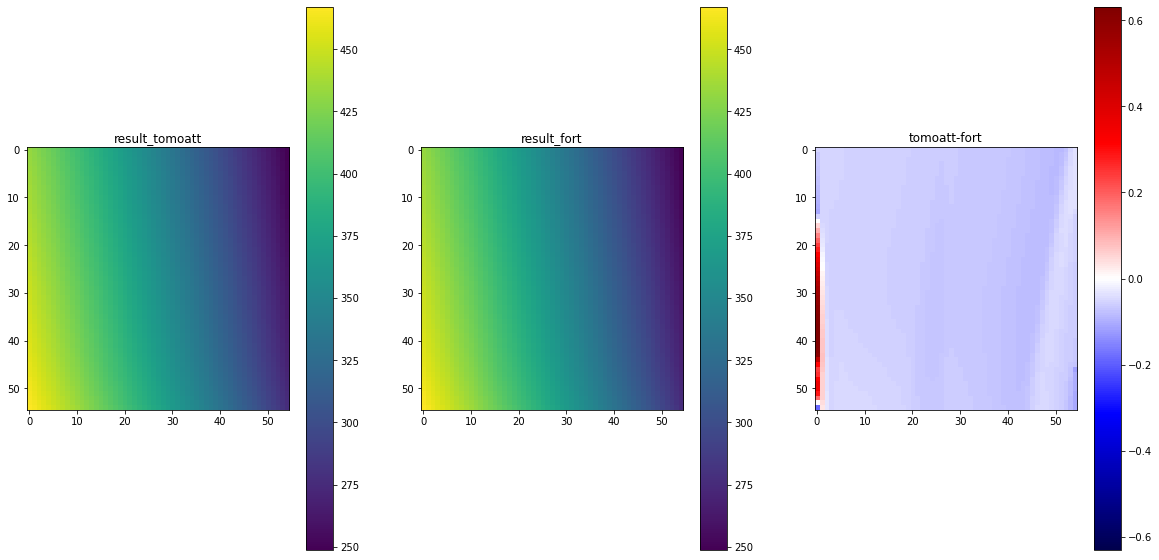

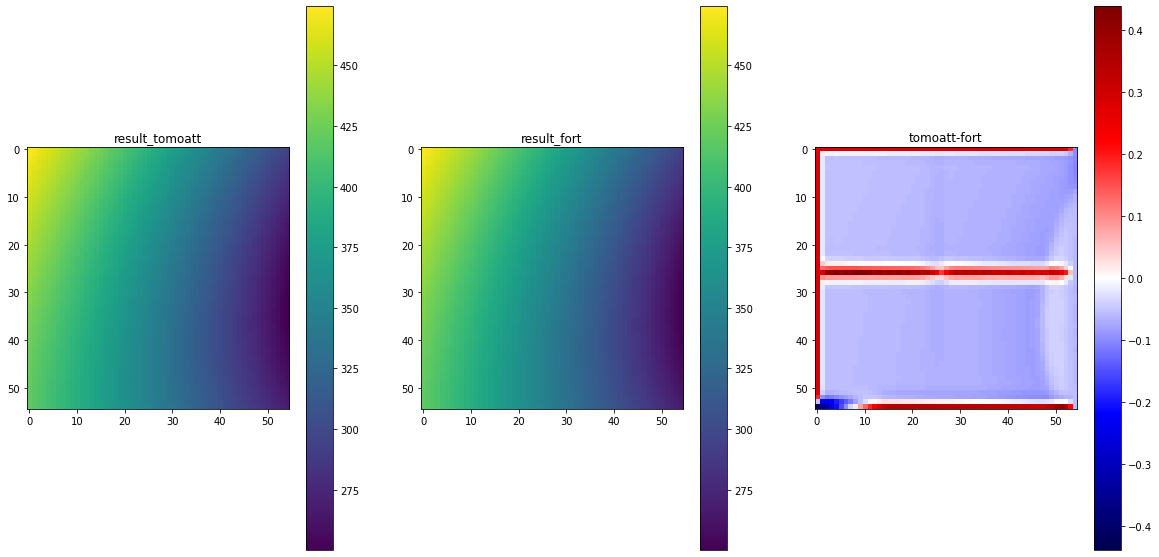

In [9]:
plot_slice(Syn_tomoatt, Syn_fort, 'p', 21, contour=False)
plot_slice(Syn_tomoatt, Syn_fort, 't', 21, contour=False)
plot_slice(Syn_tomoatt, Syn_fort, 'r', 21, contour=False)

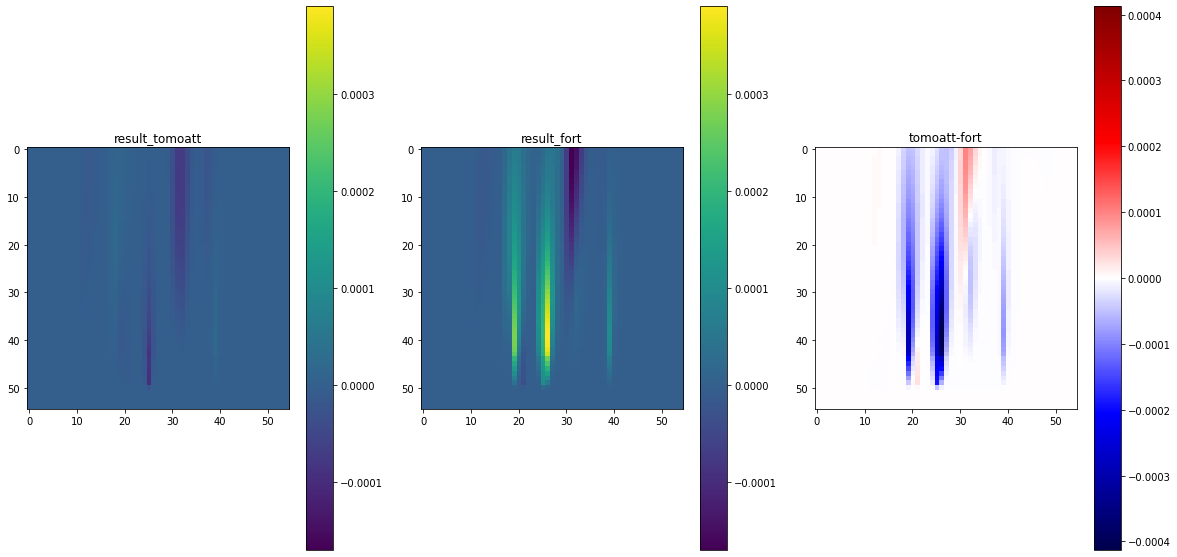

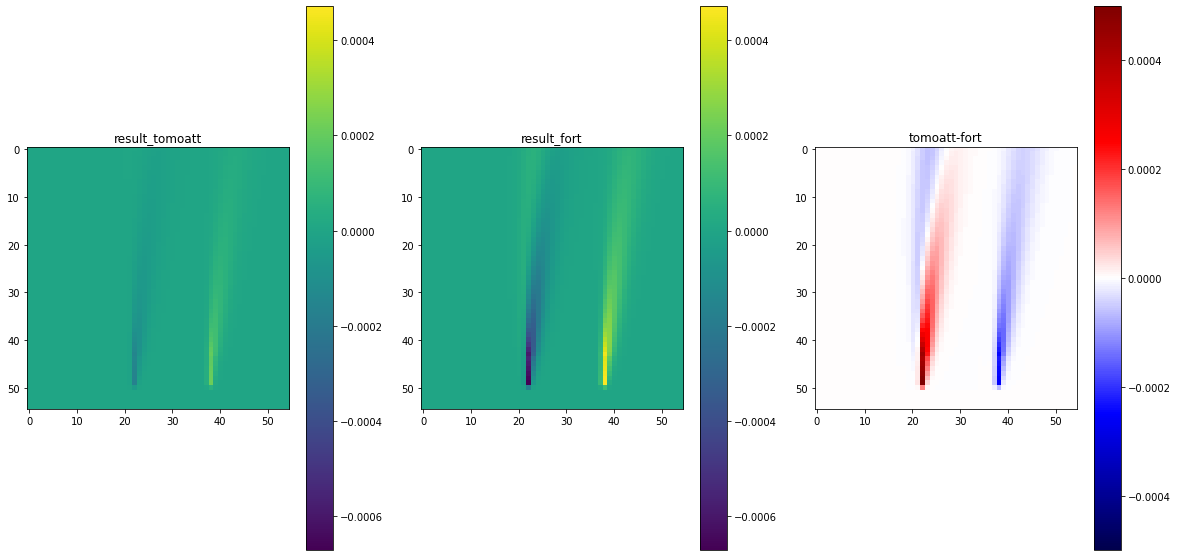

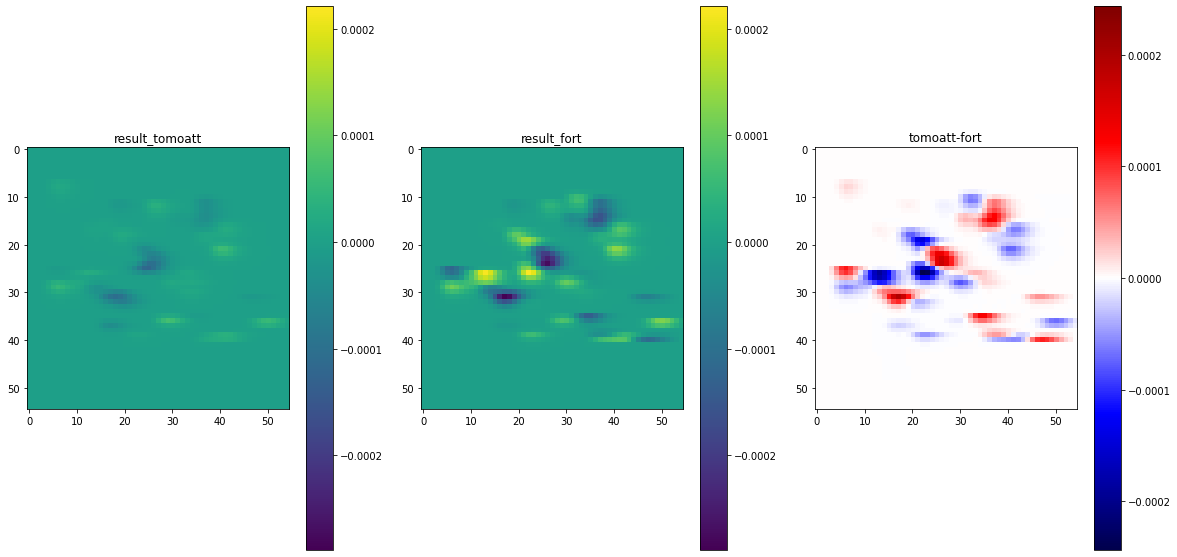

In [10]:
plot_slice(Adj_tomoatt, Adj_fort, 'p', 21, contour=False)
plot_slice(Adj_tomoatt, Adj_fort, 't', 21, contour=False)
plot_slice(Adj_tomoatt, Adj_fort, 'r', 21, contour=False)